# Specialized Wrappers

By inheriting the main wrapper class `H5File` domain-specific functionality can be added. Although properties can be registered, it can be worth the effort of inheriting the class to permanently add features to it.

The package provides two such class:
 - `H5Flow` and 
 - `H5PIV`

---

## H5Flow

To enhance the work with fluid-related HDF5 datasts, `H5Flow` is implemented, which is inherited from `H5File`. Thus, all features plus the domain specific one, that will be outlined here, are available.

For fluid data, we expect the file to have certain datasets, that are coordinates and velocities. Most likely other derived datasets may exist like gradients or other physical measured or simulated variables like pressure, for instance.

In [1]:
import numpy as np
import h5rdmtoolbox as h5tbx

In [2]:
with h5tbx.H5Flow() as h5:
    filename = h5.hdf_filename  # keep for later use
    h5.create_coordinates(x=np.linspace(0, 1, 20),
                          y=np.linspace(0, 0.5, 10),
                          z=np.linspace(-1, 1, 3),
                          coords_unit='mm')
    h5.create_velocity_datasets(u=np.random.rand(3, 10, 20),
                                v=np.random.rand(3, 10, 20),
                                w=np.random.rand(3, 10, 20),
                                dim_scales=('z', 'y', 'x'),
                                units='mm/s')
    h5.dump()

## Accessing vector data

Fluid data holds vector variables, like coordinates, velocities, gradients and more. To access them, the property `Vector` can be called. As it is generally unknown, which HDF datasets belong to a vector, we need to specify them like so:

In [3]:
with h5tbx.H5Flow(filename) as h5:
    vel = h5.Vector(names=('u', 'v', 'w'))[0:1, :, :]
vel

C:\Users\da4323\Documents\programming\GitHub\h5RDMtoolbox\h5rdmtoolbox\h5wrapper\h5file.py:1676: StandardizedNameTableWarning: Unable to write standard name table to file. It will be effective anyhow but if the file is reloaded later the choice is forgotten.
  warnings.warn(


<xarray.Dataset>
Dimensions:  (z: 1, y: 10, x: 20)
Coordinates:
  * z        (z) float64 -1.0
  * y        (y) float64 0.0 0.05556 0.1111 0.1667 ... 0.3333 0.3889 0.4444 0.5
  * x        (x) float64 0.0 0.05263 0.1053 0.1579 ... 0.8421 0.8947 0.9474 1.0
Data variables:
    u        (z, y, x) float64 0.8832 0.5548 0.569 ... 0.6085 0.8387 0.7958
    v        (z, y, x) float64 0.9467 0.4964 0.6665 ... 0.2503 0.815 0.6791
    w        (z, y, x) float64 0.1946 0.5964 0.3175 ... 0.62 0.0634 0.3117
Attributes:
    units:      mm/s
    long_name:  vector data

A `xr.Dataset` is received, which we can work on, e.g. compute the magnitude and plot it:

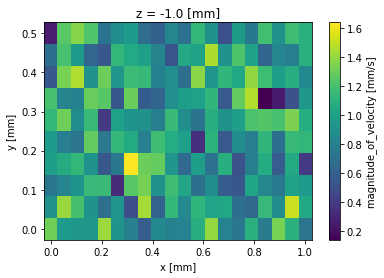

In [4]:
vel.compute_magnitude()
vel.magnitude.plot()

As seen, the vector components can be addressed passing the keyword `names` in the call-statement. We could also use the keyword `standard_name`.
To make use of the `standard_name` attribute, `VelocityDataset` is the specialized version of the `Vector` property. If sarches for the keywords `x_velocity`, `y_velocity` and `z_velocity`. This approach obviously only works if those attribtues are unique within the HDF group. If not, `name` can still be passed in the call-statement:

In [5]:
with h5tbx.H5Flow(filename) as h5:
    vel_uvw = h5.VelocityVector[0:1, :, :]
    vel_uv = h5.VelocityVector(names=('u', 'v'))[0:1, :, :]

C:\Users\da4323\Documents\programming\GitHub\h5RDMtoolbox\h5rdmtoolbox\h5wrapper\h5file.py:1676: StandardizedNameTableWarning: Unable to write standard name table to file. It will be effective anyhow but if the file is reloaded later the choice is forgotten.
  warnings.warn(


## Connecting datast to a devices
Assume we have experiment data, e.g. we measured the pressure. We can reference the measurement device in the dataset like so:

In [6]:
with h5tbx.H5Flow() as h5:
    h5.create_group('devices')
    device_grp = h5.create_group('devices/PressureSensor')
    device_grp.attrs['manufacturer'] = 'unknown'
    device_grp.create_dataset('x', data=0, units='m', standard_name='x_coordinate')
    device_grp.create_dataset('y', data=0, units='m', standard_name='y_coordinate')
    device_grp.create_dataset('z', data=0, units='m', standard_name='z_coordinate')
    ds = h5.create_dataset('pressure', data=np.random.random(100), units='Pa', standard_name='pressure',
                          device=device_grp)
    print(ds.device)
    print(type(ds.device))

Device "PressureSensor" from "unknown" @(0, 0, 0) [m])
<class 'h5rdmtoolbox.h5wrapper.h5flow.Device'>


**Alternative 1:** We can first use the `Device` class to create an object, which we write to the hdf group and then create the reference:

In [7]:
p_sensor = h5tbx.h5wrapper.h5flow.Device('PressureSensor', manufacturer='unknown',
                  x=(0, dict(units='m',standard_name='x_coordinate')),
                  y=(0, dict(units='m',standard_name='y_coordinate')),
                  z=(0, dict(units='m',standard_name='z_coordinate')))
p_sensor

Device "PressureSensor" from "unknown" @(0, 0, 0) [m])

In [8]:
with h5tbx.H5Flow() as h5:
    devices_grp = h5.create_group('devices')
    sensor_grp = p_sensor.to_hdf_group(devices_grp)
    
    ds = h5.create_dataset('pressure', data=np.random.random(100), units='Pa', standard_name='pressure',
                          device=sensor_grp)
    ds.device = sensor_grp
    print(ds.device)
    print(type(ds.device))

Device "PressureSensor" from "unknown" @(0, 0, 0) [m])
<class 'h5rdmtoolbox.h5wrapper.h5flow.Device'>


In [9]:
with h5tbx.H5Flow() as h5:    
    ds = h5.create_dataset('pressure', data=np.random.random(100), units='Pa', standard_name='pressure')
    ds.device = p_sensor

---
## H5PIV

Velocity is a vector quantity. In the HDF file each component generally is stored as an individual data variable. To get the full vector in one variable the attribute `VelocityVector` can be called. Slicing this object will assigned it with the respectve arrays from the HDF datasets. In this case x- and y-velociy datasets are siced and merged into a `xr.Dataset`. The `VelocityVector` class is wrapped around the `xr.Dataset` class and has additional methods, like `compute_magnitude()`.

Note, that `VelocityVector` is not a property of `H5PIV` by default but is added afterwards, similar to how dataarray-ccessors are added to an `xr.DataArray`.

In [10]:
with h5tbx.tutorial.get_H5PIV('minimal_flow', mode='r') as h5:
    h5.dump()
    vel = h5.VelocityVector[:]

### Post-processing with `H5PIV`

Based on standard names velocity, velocity gradients and other variables are identified. Each group therefore should have only one velocity vector, otherwise it is not clear from which to compute e.g. the turbulent kinetic energy.<br>
From each group, multiple fluid-specific post-processing methods can be called. They store the result in the respective group if required data was correcly identified:

In [11]:
with h5tbx.tutorial.get_H5PIV('vortex_snapshot', mode='r+') as h5:
    h5.dump()

## Computing PIV uncertainty

Get an example HDF filename from the ILA vortex pair example (https://www.pivtec.com/pivview.html):

To compute the uncertainty of a PIV measurement, we need to gather some specific datasets, namely the at minimum the pixel coordinates, the displacements and the raw images. The class property `UncertaintyDataset` does this for us. Calling it will return a `xarray.Dataset` with the displacement variables.

Let's load the vortex example and fetch image A and imabe B:

In [12]:
with h5tbx.tutorial.get_H5PIV('vortex_snapshot', 'r+') as h5:
    disp = h5.DisplacementVector[:,:]
    imgA = h5.imgA[:,:]
    imgB = h5.imgB[:,:]
disp

<xarray.Dataset>
Dimensions:  (y: 29, x: 31)
Coordinates:
  * y        (y) float64 -464.0 -448.0 -432.0 -416.0 ... -64.0 -48.0 -32.0 -16.0
    iy       (y) int32 16 32 48 64 80 96 112 128 ... 368 384 400 416 432 448 464
  * x        (x) float64 16.0 32.0 48.0 64.0 80.0 ... 448.0 464.0 480.0 496.0
    ix       (x) int32 16 32 48 64 80 96 112 128 ... 400 416 432 448 464 480 496
    time     int32 0
    z        float64 0.0
Data variables:
    dx       (y, x) float32 nan nan nan nan nan ... 1.127 1.073 0.8495 0.7958
    dy       (y, x) float32 nan nan nan nan nan ... 0.08971 0.117 0.07952 0.1089
Attributes:
    units:      pixel
    long_name:  vector data

The uncertainty dataset has the coordinates `x` and `y`, the displacements arrays `dx` and `dy` but also the pixel coordinates `ix` and `iy`

Next, let's create a more or less random uncertainty method. In this example we do not compute the real error but assume one, just to explain the workflow of cumputing the uncertainty from the dataset:

In [13]:
def my_uncertainty_method(uds, imgA, imgB):
    """
    Dummy uncertainty method for this tutorial.
    Returns the same dataset but with added uncertainties
    
    Parameters
    ----------
    uds: XRUncertaintyDataset
        The uncertainty dataset containing, x, y, ix, iy, dx, dy, ...
    imgA: np.ndarray
        2d PIV image A. Will not be touch in this example
    imgB: np.ndarray
        2d PIV image B. Will not be touch in this example
        
    Returns
    -------
    uds: XRUncertaintyDataset    
    """
    import xarray as xr
    xerr = 0.05
    yerr = 0.075
    udx = np.abs(uds.dx)*xerr
    uds['udx'] = xr.DataArray(dims=uds.dx.dims, data=udx,
                                        attrs={'standard_name': f'uncertainty_of_{uds.dx.standard_name}',
                                               'units': 'pixel',
                                               'piv_uncertainty_method': 'my_uncertainty_method'})
    udy = np.abs(uds.dy)*yerr
    uds['udy'] = xr.DataArray(dims=uds.dy.dims, data=udy,
                                        attrs={'standard_name': f'uncertainty_of_{uds.dy.standard_name}',
                                               'units': 'pixel',
                                               'piv_uncertainty_method': 'my_uncertainty_method'})
    return uds

In [14]:
un = disp.compute_uncertainty(my_uncertainty_method, imgA, imgB)

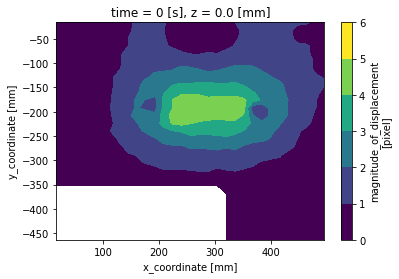

In [15]:
un.compute_magnitude()
_ = un.magnitude[:].plot.contourf(vmax=6, vmin=0)

Error in x-direction: 0.03808027505874634
Absolute relative error in x-direction: 0.05000000447034836


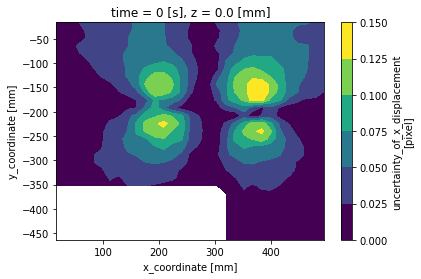

In [16]:
udx = un.get_by_standard_name('uncertainty_of_x_displacement')
_ = udx.where(np.abs(udx) < 20).plot.contourf()
print(f'Error in x-direction: {udx.mean().values}')
print(f'Absolute relative error in x-direction: {np.divide(udx, np.abs(un.dx)).mean().values}')

In [17]:
h5tbx.conventions.identifier.STRICT = False
# uncertainty_of_x_displacement is not part of the standard name table at this moment. 
# Don't check if standard names are in the respective table. this can be done by diabeling the "strictness" of checking standard names

In [18]:
with h5tbx.H5PIV(h5.hdf_filename, 'r+') as h5:
    h5.create_group('uncertainty', overwrite=True)
    h5['uncertainty'].create_dataset('delta_dx', data=un.get_by_standard_name('uncertainty_of_x_displacement'), overwrite=True)
    h5['uncertainty'].create_dataset('delta_dy', data=un.get_by_standard_name('uncertainty_of_x_displacement'), overwrite=True)

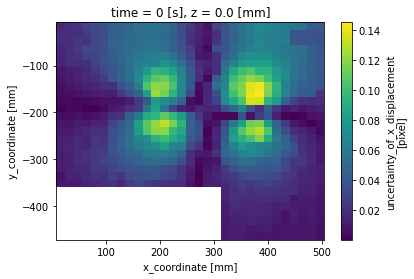

In [19]:
with h5tbx.H5PIV(h5.hdf_filename, 'r+') as h5:
    h5.dump()
    h5.uncertainty.delta_dx[:,:].plot()